# AutoEncoder on MNIST Dataset

___

In [118]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math

___

In [119]:
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


___

### NECESSARY FUNCTIONS

In [120]:
def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [121]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [122]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [123]:
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()

In [124]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)
        
        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )
        
        print(f'Valid_Loss on {epoch} epoch = {valid_loss}')
        
    print(f'Valid_Loss = {valid_loss}')

___

### BUILDING A MODEL

In [125]:
class Block(nn.Module):
    def __init__(self, in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 1, 
                 upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, 
                                          scale_factor=2, 
                                          mode='bilinear', 
                                          align_corners=False, 
                                          recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class DenoisingBlock(Block):
    def __init__(self, in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 1, 
                 upsample: bool = False):
        super().__init__(in_channels, out_channels, 
                         kernel_size, stride, upsample)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, 
                                          scale_factor=2, 
                                          mode='bilinear', 
                                          align_corners=False, 
                                          recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, 
                 base_block: nn.Module = Block, 
                 base_size: int = 8, 
                 num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, 
                 base_block: nn.Module = DenoisingBlock, 
                 base_size: int = 8, 
                 num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

___

### TRAINING AND EVALUATION OF MODEL

In [126]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device != 'cpu' :
    print(torch.cuda.get_device_name())
else:
    print('cpu')

loss_fn = nn.MSELoss()

cuda:0
Tesla T4


In [127]:
model = AutoEncoder(in_channels=1).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

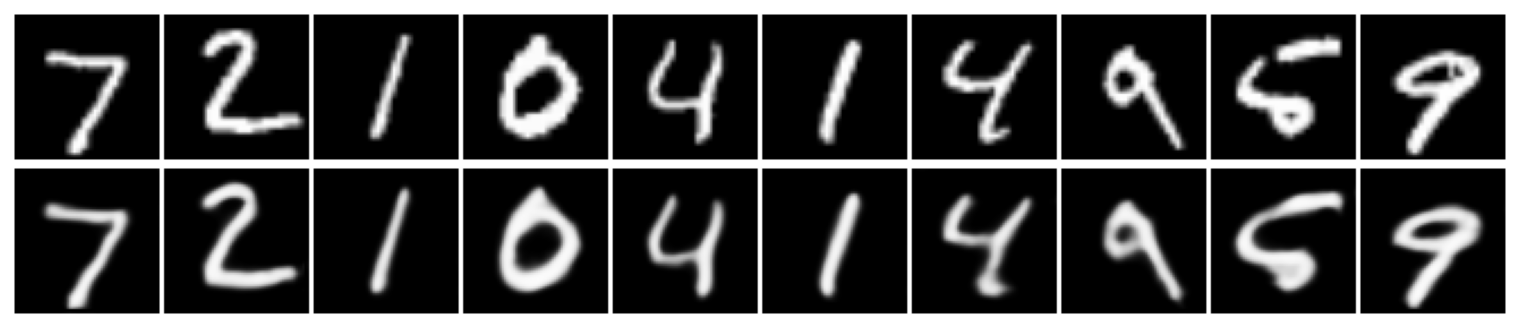

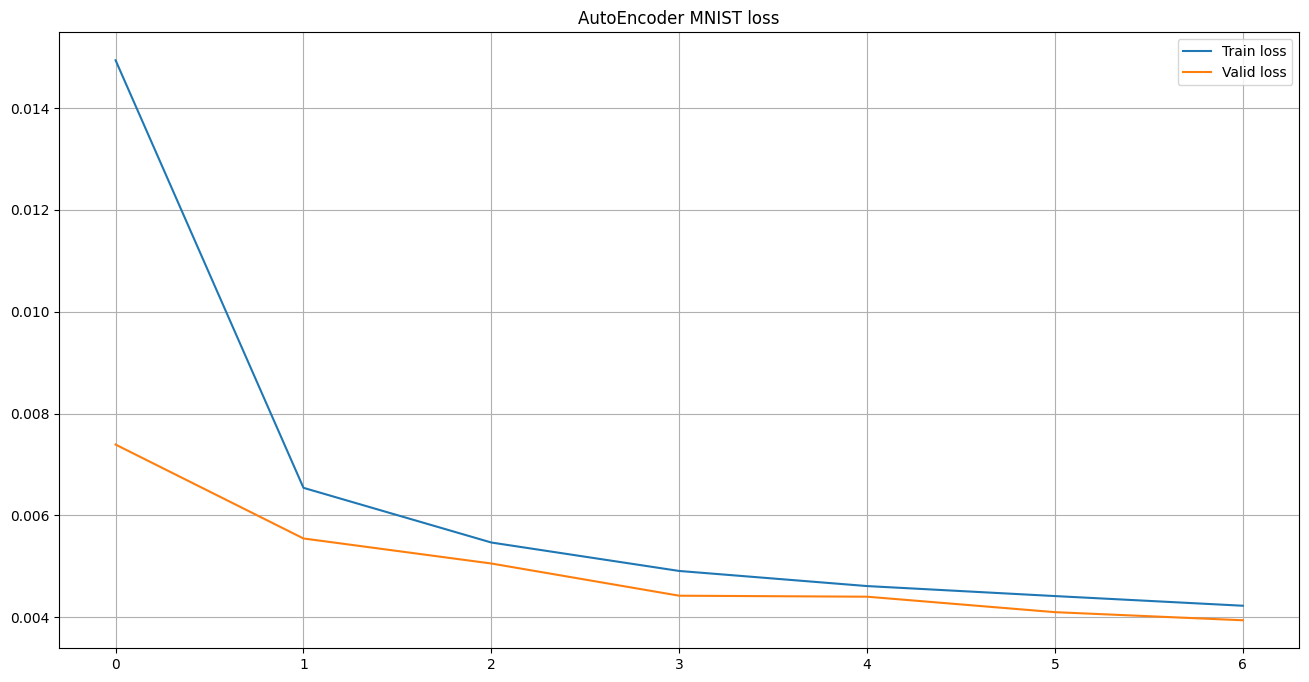

Valid_Loss on 6 epoch = 0.003939975475588927
Valid_Loss = 0.003939975475588927


In [128]:
whole_train_valid_cycle(model, 7, 'AutoEncoder MNIST')

___

In [129]:
@torch.inference_mode()
def get_interpolation(model, x1, x2):
    z1 = model.encode(x1.unsqueeze(0).to(device))
    z2 = model.encode(x2.unsqueeze(0).to(device))

    weights = torch.linspace(start=0, end=1, steps=7).unsqueeze(1).to(device)

    zs = z2 * weights + z1 * (1 - weights)

    images = model.decode(zs)

    plt.figure(figsize=(14, 4))

    plt.imshow(T.ToPILImage()(make_grid(images, nrow=7, pad_value=1)))

    plt.axis('off')

    plt.show()

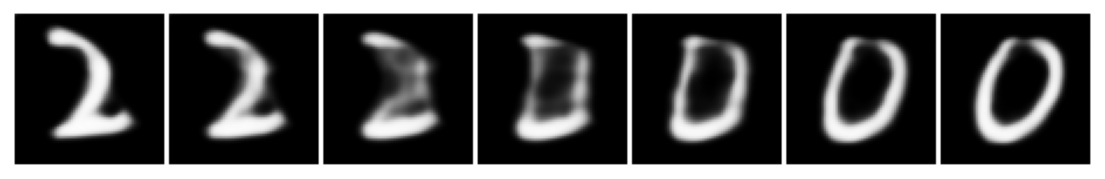

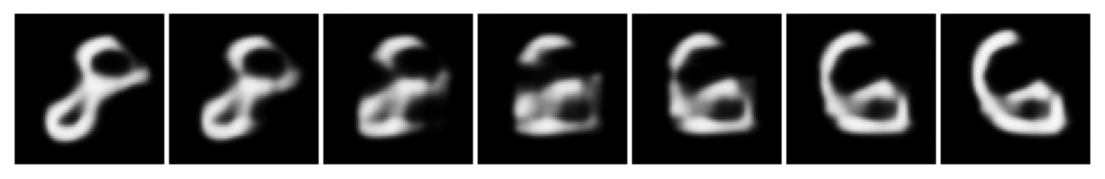

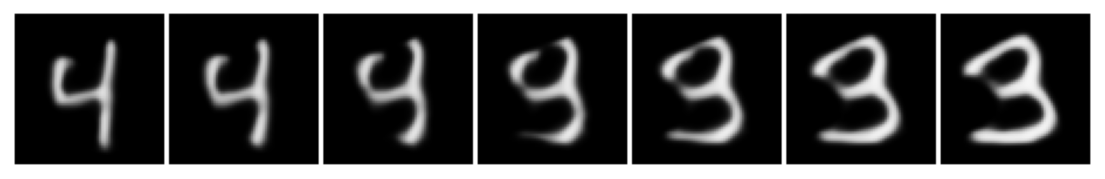

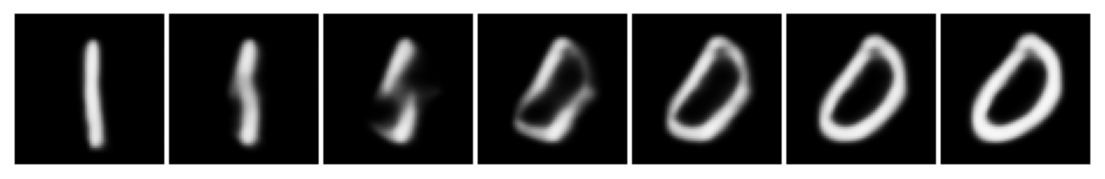

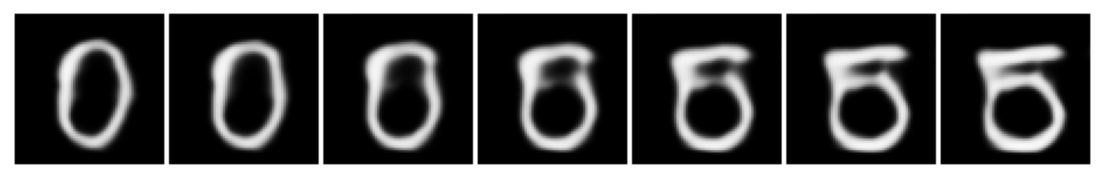

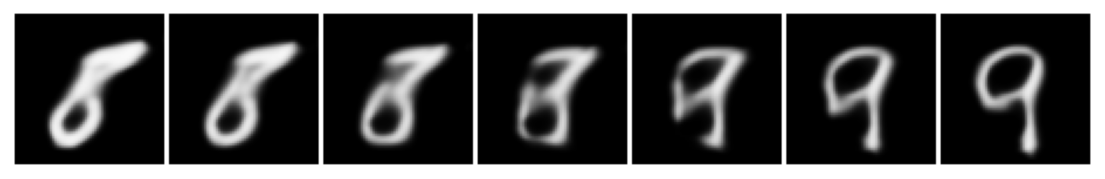

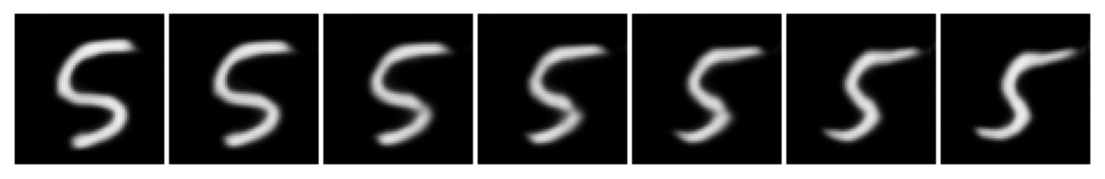

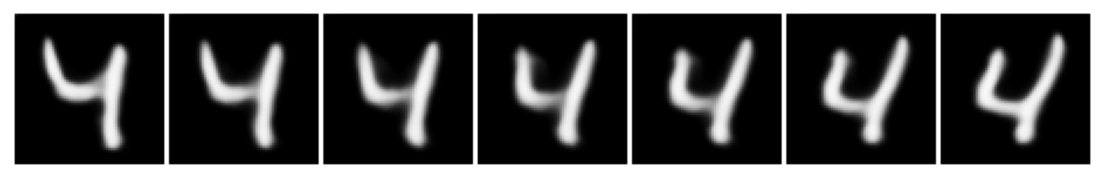

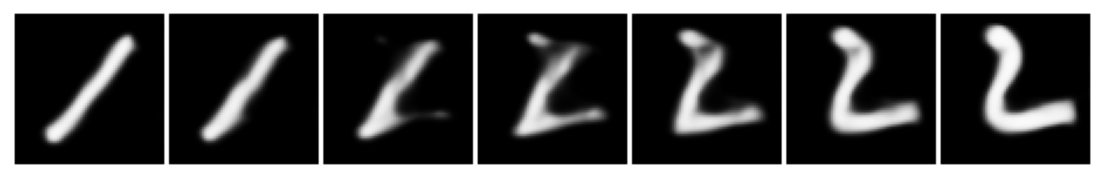

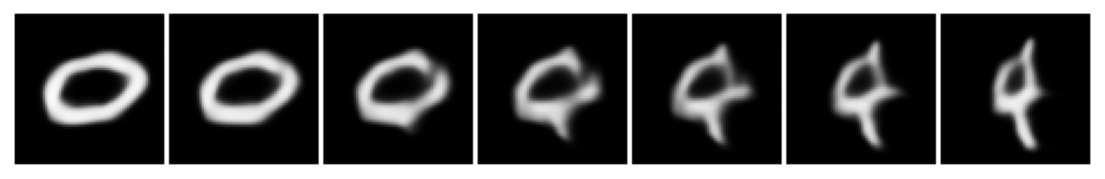

In [130]:
for _ in range(10):
    idx1, idx2 = np.random.randint(len(valid_dataset), size=2)
    get_interpolation(model, valid_dataset[idx1][0], valid_dataset[idx2][0])

In [131]:
de_model = DenoisingAutoEncoder(in_channels=1).to(device)

optimizer = Adam(de_model.parameters(), lr=1e-3)

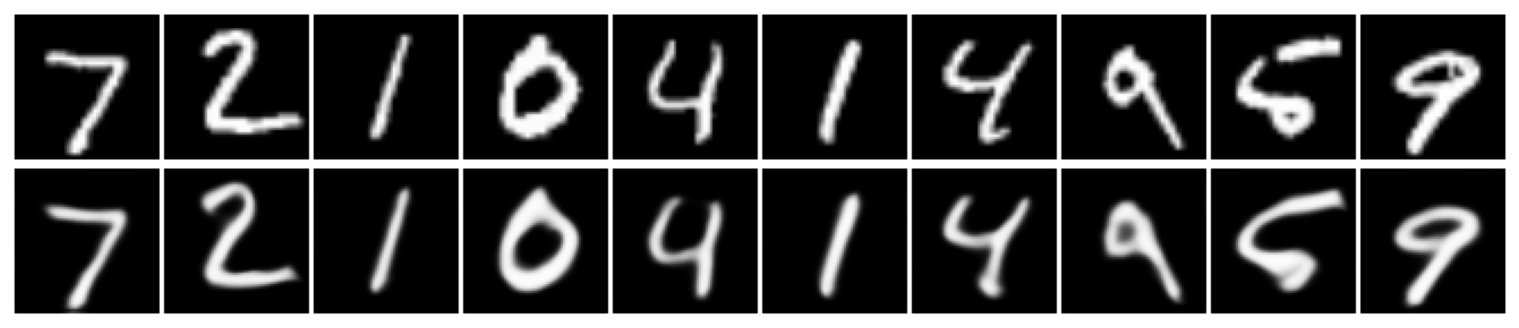

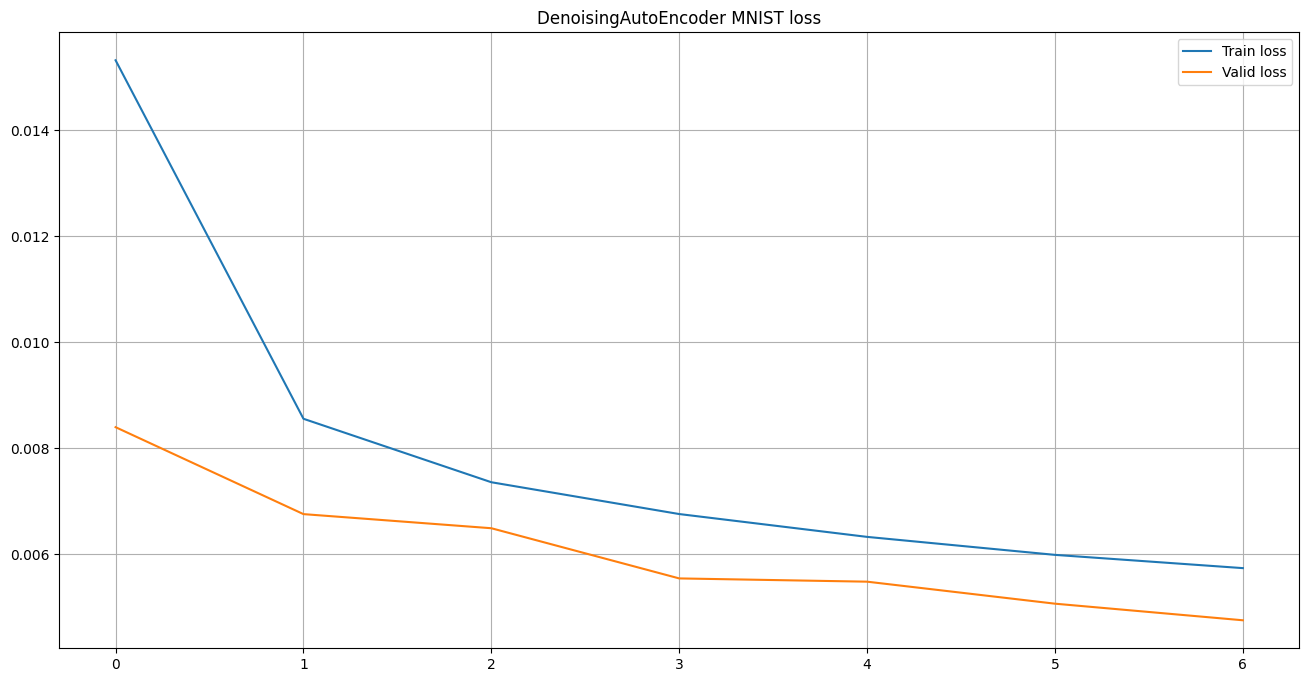

Valid_Loss on 6 epoch = 0.004750039177045178
Valid_Loss = 0.004750039177045178


In [132]:
whole_train_valid_cycle(de_model, 7, 'DenoisingAutoEncoder MNIST')

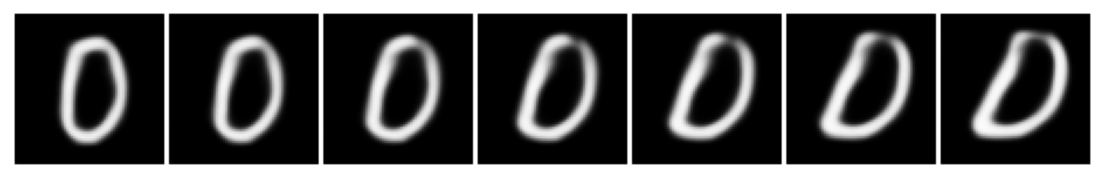

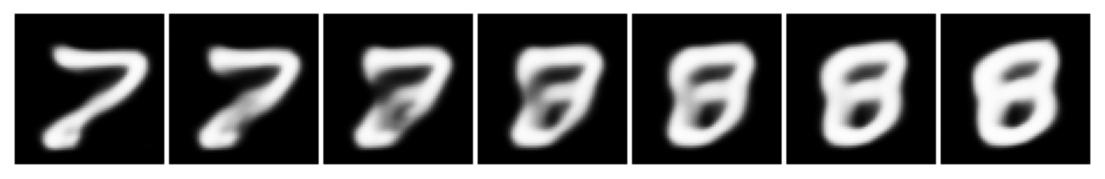

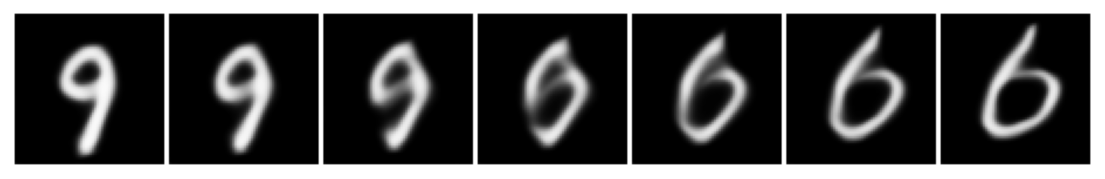

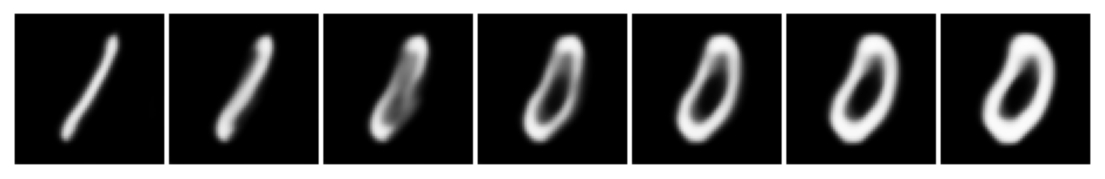

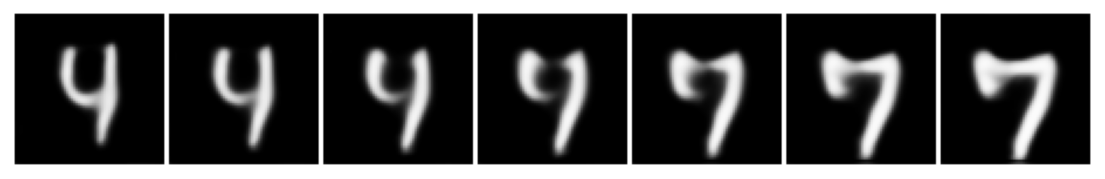

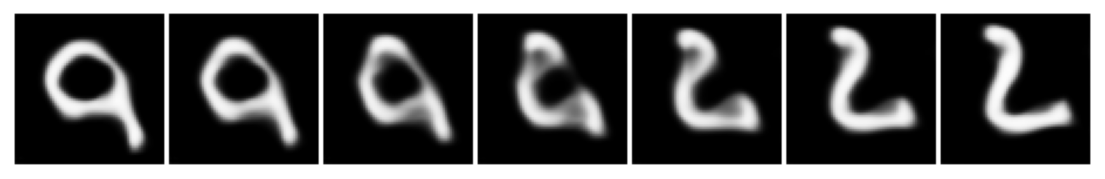

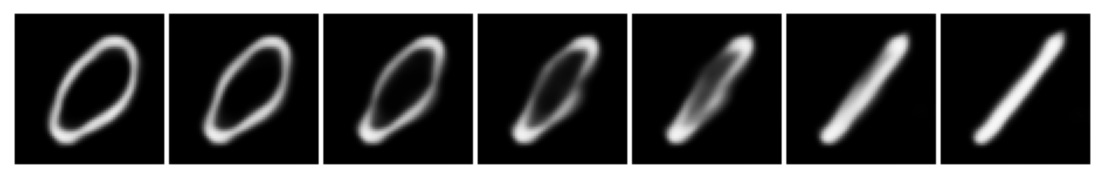

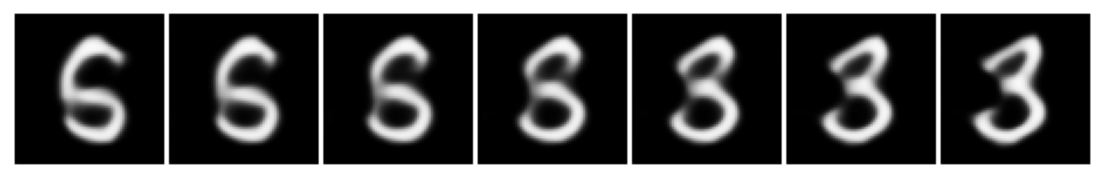

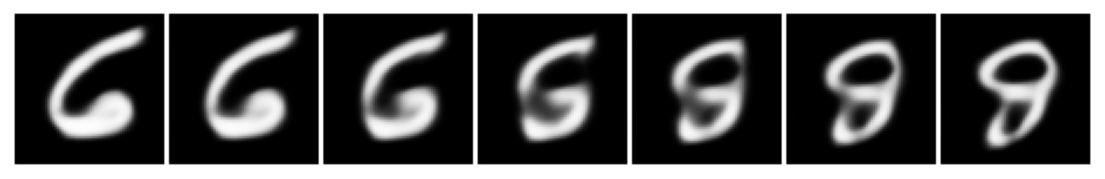

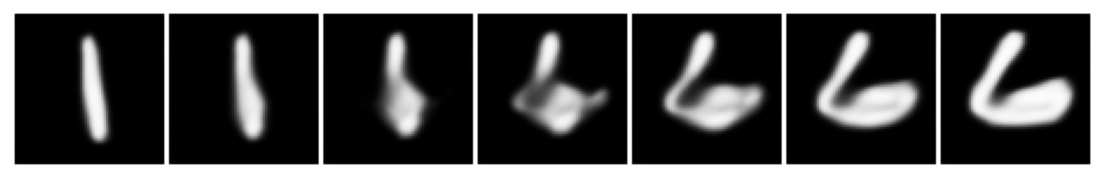

In [133]:
for _ in range(10):
    idx1, idx2 = np.random.randint(len(valid_dataset), size=2)
    get_interpolation(de_model, valid_dataset[idx1][0], valid_dataset[idx2][0])

In [134]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None):
    model.eval()
    
    total = 0
    
    latent = []
    labels = []
    
    for x, y in loader:
        z = model.encode(x.to(device)).cpu()
        
        latent.append(z)
        labels.append(y)
        
        total += y.shape[0]
        
        if count is not None and total >= count:
            break
            
    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()
    
    return latent, labels

In [135]:
x, y = get_latent_labels(de_model, train_loader, 1000)

In [136]:
x

array([[-1.5809656 , -1.3592597 , -1.0249474 , ..., -3.66059   ,
        -3.8906696 , -1.874637  ],
       [-2.3013735 , -1.9527217 , -3.1940148 , ..., -4.3379126 ,
         3.6936262 , -1.5168271 ],
       [-0.5518556 , -1.2203233 , -3.9121492 , ..., -2.7741868 ,
         0.7669603 , -2.8173182 ],
       ...,
       [-1.3634788 , -1.1145233 ,  1.921629  , ..., -2.9955359 ,
        -1.1713445 ,  1.3824859 ],
       [-1.5693383 , -0.48220208,  1.6173553 , ..., -1.1308413 ,
        -4.164803  , -2.0581198 ],
       [ 0.18193127,  1.1858025 ,  0.83837414, ..., -1.9067646 ,
        -5.8511624 ,  1.5812814 ]], dtype=float32)

In [137]:
x.shape, y.shape

((1000, 128), (1000,))

___

### TRAIN RANDOM FOREST

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
clf = RandomForestClassifier(random_state=0).fit(x, y)

In [148]:
x_valid, y_valid = get_latent_labels(de_model, valid_loader, count=10000)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [149]:
x_train, y_train = get_latent_labels(de_model, train_loader, count=1000)

___

### SAVE EMBEDINGS

In [150]:
def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

In [151]:
save_embeddings(x_train, y_train, x_valid, y_valid)

___